# Imports

In [13]:
import torch
import random
import gc

import pandas as pd
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import itertools as it
import matplotlib.ticker as ticker

from tqdm.notebook import trange, tqdm
from copy import deepcopy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [14]:
if torch.cuda.is_available():
    print("PyTorch GPU is available")
else:
    print("PyTorch GPU is not available")
DEVICE = "cpu"

PyTorch GPU is available


In [15]:
RANDOM_SEED = 10

# Seed the RNG for all devices (both CPU and CUDA)
torch.manual_seed(RANDOM_SEED)
# Set python seed
random.seed(RANDOM_SEED)
# Set numpy seed
np.random.seed(RANDOM_SEED)
# Force cuDNN to deterministically select an algorithm
# *possibly at the cost of reduced performance
torch.backends.cudnn.benchmark = False

# Worker initialization function for data loaders (simplest approach)
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() + worker_id) % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g_train = torch.Generator().manual_seed(RANDOM_SEED)

# Training model on artificial data

In [4]:
X_data = np.linspace(-1, 1, 101)
num_coef = 4
coef = [-100, 2, 1, 100]
y_data = 0
for i in range(num_coef):
    y_data += coef[i] * np.power(X_data, i)
    y_data += np.random.randn(*X_data.shape) * 20.5

Plotting the data

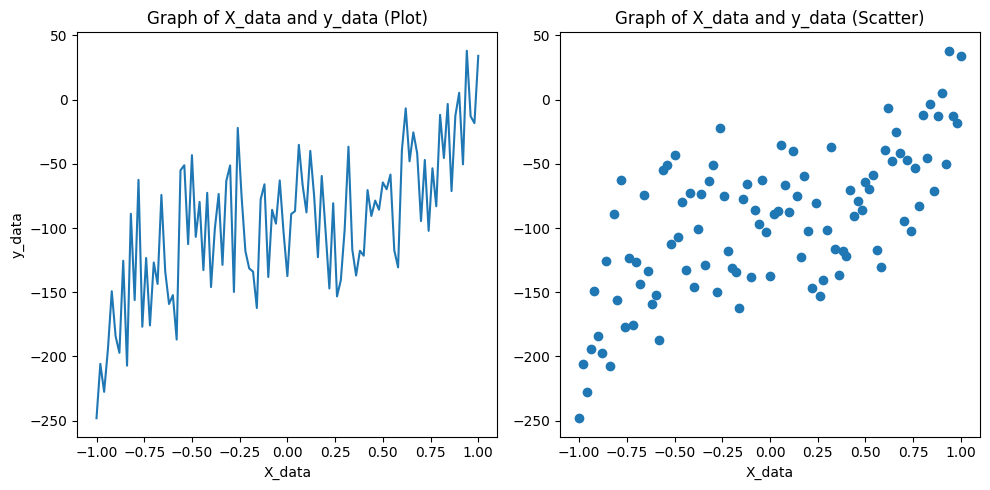

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot with plot
axs[0].plot(X_data, y_data)
axs[0].set_xlabel('X_data')
axs[0].set_ylabel('y_data')
axs[0].set_title('Graph of X_data and y_data (Plot)')

# Plot with scatter
axs[1].scatter(X_data, y_data)
axs[1].set_xlabel('X_data')
axs[1].set_title('Graph of X_data and y_data (Scatter)')

plt.tight_layout()
plt.show()

In [16]:
class PolynomialRegression(nn.Module):
    """
    A class representing a polynomial regression model.

    This class inherits from the `nn.Module` class of PyTorch and implements
    the necessary methods for training and evaluating a polynomial regression model.

    Attributes:
    - degree (int): The degree of the polynomial regression model.
    - weights (nn.Parameter): The learnable weights of the model.

    Methods:
    - __init__(self, degree): Initializes a new instance of the PolynomialRegression class.
    - forward(self, x): Performs a forward pass through the model.
    - fit(self, X, y, learning_rate, num_epochs, batch_size, reg_lambda, verbose): Trains the model using the given input data and labels.
    - plot_loss(self): Plots the loss over epochs.
    - find_best_parameters(X, y, learning_rates, batch_sizes, reg_lambdas, degrees, model_type, num_epochs, validation_ratio, shuffle):
    Finds the best parameters for the model by performing a grid search over the specified hyperparameters.
    - plot_data_and_prediction(self, X, y): Plots the data points and the prediction line.
    """

    def __init__(self, degree):
        """
        Parameters:
        - degree (int): The degree of the polynomial regression model.
        """
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        self.weights = nn.Parameter(torch.randn(degree + 1, 1))
        
    def forward(self, x):
        x_powers = torch.vstack([x**i for i in range(self.degree + 1)]).T
        return torch.matmul(x_powers, self.weights).squeeze()

    def fit(self, X, y, learning_rate=0.01, num_epochs=100, batch_size=32, reg_lambda=0.01, verbose=True):
            """
            Trains the model using the given input data and labels.

            Parameters:
            - X (torch.Tensor): Input data tensor.
            - y (torch.Tensor): Label tensor.
            - learning_rate (float): Learning rate for the optimizer (default: 0.01).
            - num_epochs (int): Number of training epochs (default: 100).
            - batch_size (int): Batch size for training (default: 32).
            - reg_lambda (float): Regularization lambda value (default: 0.01).
            - verbose (bool): Whether to print the loss every 10 epochs (default: True).
            """
            
            criterion = nn.MSELoss()
            optimizer = optim.SGD(self.parameters(), lr=learning_rate)
            
            # Create a dataset and dataloader for batch training
            dataset = torch.utils.data.TensorDataset(
                torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32))
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True,
                drop_last=True, num_workers=0, worker_init_fn=seed_worker, generator=g_train)
            
            # Initialize an array to store the loss values for each epoch
            self.loss_arr = np.zeros(num_epochs)
            
            # Training loop
            if verbose: epoch_arr = tqdm(range(num_epochs))
            else: epoch_arr = range(num_epochs)
            
            for epoch in epoch_arr:
                running_loss = 0.0
                for inputs, targets in dataloader:
                    inputs = inputs.to(DEVICE)
                    targets = targets.to(DEVICE)
                    
                    optimizer.zero_grad() # Zero the gradients
                    outputs = self(inputs) # Forward pass
                    loss = criterion(outputs, targets) # Compute the loss
                    
                    l2_regularization = torch.norm(
                        torch.cat([p.view(-1) for p in self.parameters()]),
                        p=2
                    ).to(DEVICE) # Add L2 regularization to the loss
                    loss += reg_lambda * l2_regularization
                    loss.backward() # Backward pass
                    optimizer.step() # Update the weights
                    running_loss += loss.item() # Accumulate the loss
                    
                # Compute the average loss for the epoch
                self.loss_arr[epoch] = running_loss / len(dataloader)
                    
                # Print the loss every 10 epochs
                if verbose and (epoch+1) % 10 == 0:
                    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {self.loss_arr[epoch]:.4f}')
                    
                del inputs
                del targets
                del l2_regularization
                gc.collect()
                torch.cuda.empty_cache()
    
    def plot_loss(self):
        """
        Plots the loss over epochs.

        This function plots the loss values stored in the `loss_arr` attribute
        of the object. It creates a line plot with the x-axis representing the
        epochs and the y-axis representing the loss values. The plot is then
        displayed.
        """
        plt.plot(self.loss_arr)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss over Epochs')
        plt.show()

    @staticmethod
    def find_best_parameters(X, y, learning_rates, batch_sizes, reg_lambdas, degrees, model_type,
            num_epochs=100,
            validation_ratio=0.2,
            shuffle=True
        ):
            """
            Finds the best parameters for the model by performing a grid search over the specified hyperparameters.

            Parameters:
            - X (numpy.ndarray): Input features.
            - y (numpy.ndarray): Target values.
            - learning_rates (list): List of learning rates to try.
            - batch_sizes (list): List of batch sizes to try.
            - reg_lambdas (list): List of regularization lambdas to try.
            - degrees (list): List of degrees to try for polynomial regression.
            - model_type (class): The type of model to use for training and evaluation.
            - num_epochs (int): Number of epochs to train the model.
            - validation_ratio (float): Ratio of the data to be used for validation (default=0.2).
            - shuffle (bool): Whether to shuffle the data before splitting into train/validation sets (default=True).
            """

            # Split data into train/validation sets
            X_train, X_validation, y_train, y_validation = train_test_split(
                X, y, test_size=validation_ratio, random_state=RANDOM_SEED, shuffle=shuffle)
            
            best_loss = float('inf')
            best_learning_rate = None
            best_batch_size = None
            best_reg_lambda = None
            best_degree = None
            best_model = None
            
            X_validation = torch.tensor(X_validation, dtype=torch.float32).to(DEVICE)
            y_validation = torch.tensor(y_validation, dtype=torch.float32).to(DEVICE)
            
            # Perform grid search over the hyperparameters
            for learning_rate, batch_size, reg_lambda, degree in tqdm(
                it.product(learning_rates, batch_sizes, reg_lambdas, degrees),
                total=len(learning_rates) * len(batch_sizes) * len(reg_lambdas) * len(degrees)):
                
                # Fit the model with the current hyperparameters
                current_model = model_type(degree).to(DEVICE)
                current_model.fit(X_train, y_train, learning_rate, num_epochs, batch_size, reg_lambda, verbose=False)
                
                # Calculate validation loss
                validation_loss = nn.MSELoss()(current_model(X_validation), y_validation)
                
                # Update best parameters if the current validation loss is better
                if validation_loss < best_loss:
                    best_model = deepcopy(current_model)
                    best_loss = validation_loss
                    best_learning_rate = learning_rate
                    best_batch_size = batch_size
                    best_reg_lambda = reg_lambda
                    best_degree = degree
                    
                del current_model
            
            gc.collect()
            torch.cuda.empty_cache()

            # Print the best parameters found
            print(f"Best parameters: learning_rate={best_learning_rate}, batch_size={best_batch_size}, "
                  f"reg_lambda={best_reg_lambda}, degree={best_degree}")
            print(f"Best loss: {best_loss}")
            return best_model
        
    def plot_data_and_prediction(self, X, y):
        """
        Plots the data points and the prediction line.

        Parameters:
        X (array-like): The input data points.
        y (array-like): The corresponding target values.
        """
        plt.scatter(X, y, label='Data')
        plt.plot(X, self.forward(torch.tensor(X, dtype=torch.float32)).detach().numpy(),
                 color='red', label='Prediction')
        plt.xlabel('X')
        plt.ylabel('y')
        plt.title('Data and Prediction')
        plt.legend()
        plt.show()

Train model with default hyperparameters (learning_rate=0.01, num_epochs=100, batch_size=32, reg_lambda=0.01) and polynomial_degree=4

In [7]:
DEVICE = "cpu"
art_data_model = PolynomialRegression(4).to(DEVICE)
art_data_model.fit(X_data, y_data)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/100, Loss: 4684.9315

Epoch 20/100, Loss: 2783.3415

Epoch 30/100, Loss: 2112.8835

Epoch 40/100, Loss: 1894.9177

Epoch 50/100, Loss: 1692.0295

Epoch 60/100, Loss: 1625.0295

Epoch 70/100, Loss: 1553.7390

Epoch 80/100, Loss: 1611.9135

Epoch 90/100, Loss: 1592.2646

Epoch 100/100, Loss: 1531.1809


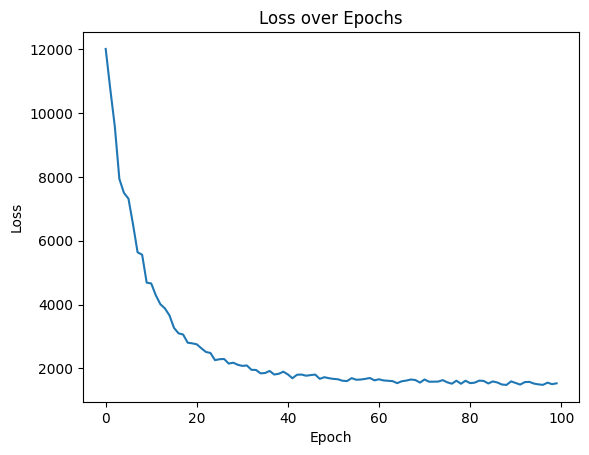

In [8]:
art_data_model.plot_loss()

Perform grid-search for best hyperparameters

In [10]:
learning_rates = [0.0001, 0.001, 0.01, 0.1]
batch_sizes = [4, 8, 16]
reg_lambdas = [0.0001, 0.001, 0.01]
degrees = [4]
best_model = PolynomialRegression.find_best_parameters(X_data, y_data, learning_rates, batch_sizes, reg_lambdas, degrees,
    model_type=lambda degree: PolynomialRegression(degree))

  0%|          | 0/36 [00:00<?, ?it/s]

Best parameters: learning_rate=0.1, batch_size=8, reg_lambda=0.01, degree=4

Best loss: 1505.3157958984375


Best model prediction

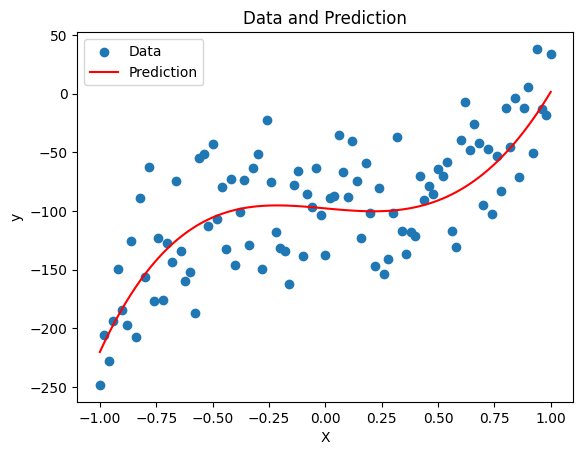

In [11]:
best_model.plot_data_and_prediction(X_data, y_data)

Saving best model weights and the whole model

In [12]:
torch.save(best_model.state_dict(), 'art_data_best_model_params.pth') # Save the model parameters
torch.save(best_model, 'art_data_best_model.pth') # Save the entire model

# Training model for Netflix Stock Price data
Data was acquired from www.kaggle.com/jainshukal/netflix-stock-price

In [17]:
# Read the CSV file
df = pd.read_csv("NFLX.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-12-16,119.800003,123.000000,118.089996,122.639999,122.639999,13181000
1,2015-12-17,123.970001,126.349998,122.419998,122.510002,122.510002,17284900
2,2015-12-18,120.849998,122.190002,117.919998,118.019997,118.019997,17948100
3,2015-12-21,119.510002,119.589996,115.660004,116.629997,116.629997,11670000
4,2015-12-22,117.300003,117.430000,114.860001,116.239998,116.239998,9689000
...,...,...,...,...,...,...,...
1002,2019-12-10,296.119995,298.940002,292.019989,293.119995,293.119995,10476100
1003,2019-12-11,294.489990,299.429993,294.200012,298.929993,298.929993,5589800
1004,2019-12-12,295.670013,299.170013,295.059998,298.440002,298.440002,4766600
1005,2019-12-13,298.500000,301.799988,297.250000,298.500000,298.500000,3879700


In [18]:
# Check the equality of the 'Close' and 'Adj Close' columns
df["Close"].equals(df["Adj Close"])

True

We delete the column "Adj Close" because it is similar to "Close"

In [19]:
del df["Adj Close"]

In [20]:
class NInputPolynomialRegression(PolynomialRegression):
    """
    A class representing a polynomial regression model with multiple inputs.

    This class inherits from the `PolynomialRegression` class and extends it to support
    polynomial regression models with multiple input variables.

    Attributes:
    - degree (int): The degree of the polynomial regression model.
    - num_inputs (int): The number of input variables.
    - polynomials (nn.ModuleList): A list of linear layers representing the polynomials for each input variable.
    - bias (nn.Parameter): The learnable bias parameter of the model.

    Methods:
    - __init__(self, degree, num_inputs): Initializes a new instance of the NInputPolynomialRegression class.
    - forward(self, x): Performs a forward pass through the model.
    - plot_data_and_prediction(self, df, scaler): Plots the data points and the prediction line.
    """

    def __init__(self, degree, num_inputs):
        """
        Parameters:
        - degree (int): The degree of the polynomial regression model.
        - num_inputs (int): The number of input variables.
        """
        super(PolynomialRegression, self).__init__()
        self.degree = degree
        self.num_inputs = num_inputs
        self.polynomials = nn.ModuleList([nn.Linear(num_inputs, 1) for _ in range(degree)])
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        output = torch.zeros(x.shape[0]).to(DEVICE)
        for idx, polynomial in enumerate(self.polynomials):
            output += polynomial(x**(idx+1)).squeeze()
        return output + self.bias

    def plot_data_and_prediction(self, df, scaler):
        """
        Plots the data points and the prediction line.

        Parameters:
        df (pandas.DataFrame): The input dataframe containing the data points.
        scaler (object): The scaler object used to scale the 'Volume' column.
        """
        _, ax = plt.subplots()
        # Plot real data
        volume_unscaled = scaler.inverse_transform(df['Volume'].values.reshape(-1, 1)).flatten()
        ax.plot(df['Date'].values, volume_unscaled, label='Data')
        
        # Plot predicted data
        X = torch.tensor(df.drop(['Date', 'Volume'], axis=1).values, dtype=torch.float32)
        y_pred = self.forward(X).detach().numpy()
        y_pred_unscaled = scaler.inverse_transform(y_pred.reshape(-1, 1)).flatten()
        ax.plot(df['Date'].values, y_pred_unscaled, color='red', label='Prediction')
        
        # Modify x-axis ticks
        ax.set_xlabel("Date")
        ax.set_ylabel("Volume")
        ax.set_title('Data and Prediction')
        ax.xaxis.set_major_locator(ticker.AutoLocator())
        plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
        
        plt.show()

We will use scaled data to evade the overflow

In [21]:
# Create a copy of the DataFrame without the "Date" column
df_norm = df.drop("Date", axis=1).copy()

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Normalize the columns
df_norm[df_norm.columns] = scaler.fit_transform(df_norm[df_norm.columns])
df_norm = pd.concat([df["Date"], df_norm], axis=1)

# Display the normalized DataFrame
df_norm

,Date,Open,High,Low,Close,Volume
0,2015-12-16,0.115108,0.113143,0.114490,0.118538,0.203625
1,2015-12-17,0.127344,0.123039,0.127488,0.118151,0.275884
2,2015-12-18,0.118189,0.110750,0.113980,0.104795,0.287562
3,2015-12-21,0.114257,0.103069,0.107195,0.100660,0.177020
4,2015-12-22,0.107773,0.096688,0.104794,0.099500,0.142140
...,...,...,...,...,...,...
1002,2019-12-10,0.632464,0.632891,0.636598,0.625647,0.155999
1003,2019-12-11,0.627681,0.634339,0.643142,0.642929,0.069963
1004,2019-12-12,0.631143,0.633571,0.645724,0.641472,0.055469
1005,2019-12-13,0.639447,0.641340,0.652298,0.641650,0.039853


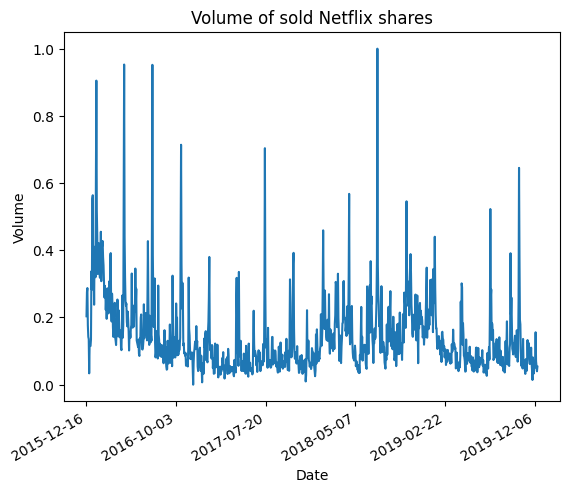

In [10]:
# Visualize the data
fig, ax = plt.subplots()
ax.plot(df_norm["Date"], df_norm["Volume"])
ax.set_xlabel("Date")
ax.set_ylabel("Volume")
ax.set_title("Volume of sold Netflix shares")
ax.xaxis.set_major_locator(ticker.AutoLocator())
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

Train model with hyperparameters learning_rate=0.0001, num_epochs=100, batch_size=8, reg_lambda=0.001 and polynomial_degree=6

In [26]:
DEVICE = "cpu"
netflix_data_model = NInputPolynomialRegression(degree=6, num_inputs=4).to(DEVICE)
netflix_data_model.fit(
    df_norm.drop(['Date', 'Volume'], axis=1).values,
    df_norm['Volume'].values,
    batch_size=8,
    reg_lambda=0.001,
    learning_rate=0.0001
)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 10/100, Loss: 0.0461
Epoch 20/100, Loss: 0.0409
Epoch 30/100, Loss: 0.0389
Epoch 40/100, Loss: 0.0368
Epoch 50/100, Loss: 0.0360
Epoch 60/100, Loss: 0.0355
Epoch 70/100, Loss: 0.0348
Epoch 80/100, Loss: 0.0340
Epoch 90/100, Loss: 0.0335
Epoch 100/100, Loss: 0.0328


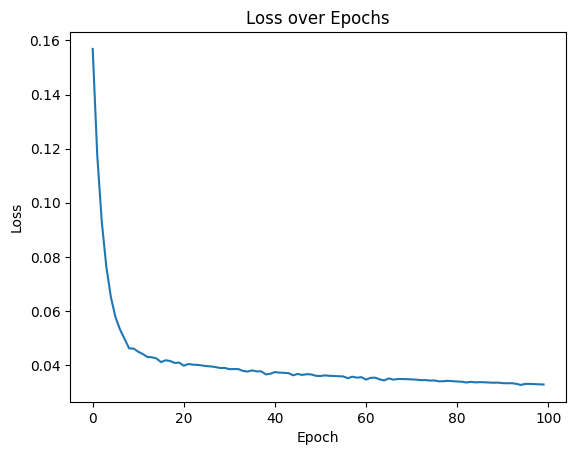

In [27]:
netflix_data_model.plot_loss()

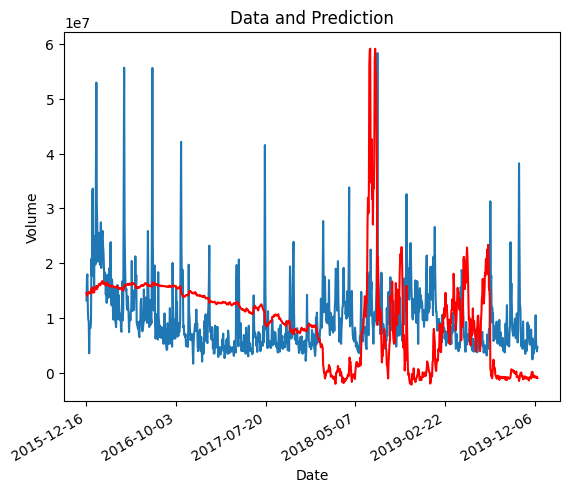

In [28]:
scaler_volume = MinMaxScaler().fit(df['Volume'].values.reshape(-1, 1))
netflix_data_model.plot_data_and_prediction(df_norm, scaler_volume)

Perform grid-search for best hyperparameters

In [22]:
learning_rates = [0.0001, 0.001, 0.01]
batch_sizes = [4, 8]
reg_lambdas = [0.001, 0.01]
degrees = [4, 5, 6, 7]
best_model = NInputPolynomialRegression.find_best_parameters(
    df_norm.drop(['Date', 'Volume'], axis=1).values,
    df_norm['Volume'].values, learning_rates, batch_sizes, reg_lambdas, degrees,
    model_type=lambda degree: NInputPolynomialRegression(degree, 4))

  0%|          | 0/48 [00:00<?, ?it/s]

Best parameters: learning_rate=0.01, batch_size=4, reg_lambda=0.001, degree=7
Best loss: 0.01513595413416624


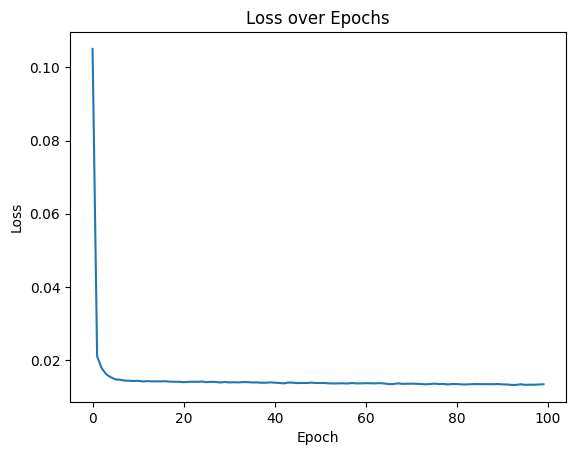

In [23]:
best_model.plot_loss()

Best-model prediction

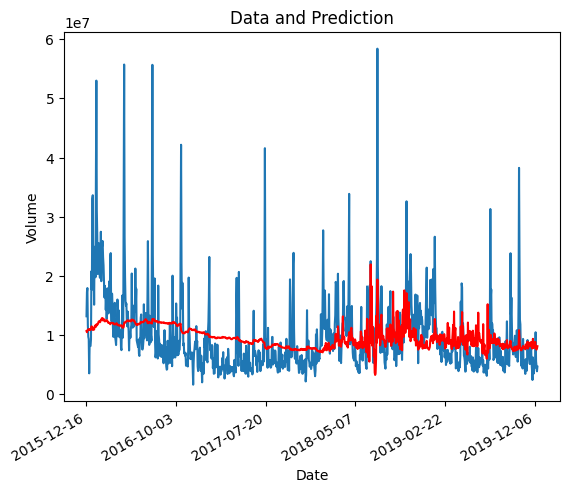

In [25]:
scaler_volume = MinMaxScaler().fit(df['Volume'].values.reshape(-1, 1))
best_model.plot_data_and_prediction(df_norm, scaler_volume)

Saving best model weights and the whole model

In [26]:
torch.save(best_model.state_dict(), 'netflix_sales_best_model_params.pth') # Save the model parameters
torch.save(best_model, 'netflix_sales_best_model.pth') # Save the entire model

# Висновок
У роботі розглядалася ефективність прогнозування штучних даних з великою дисперсією та кількості проданих акцій Netflix за допомогою поліноміальної регресії. Модель була реалізована з використанням засобів бібліотеки pytorch, навчання проводилось за допомогою стохастичного градієнтного спуску з використанням міні-пакетів. Для зменшення перенавчання моделі використовувалась MSE з регуляризацією L2 (що забезпечує менші значення ваг). Як бачимо, на першому наборі даних така модель показала себе доволі успішно, навчившись визначати загальні закономірності даних. Для другого набору (реальні дані), модель показала себе гірше, адже на відміну від першого вони не були згенеровані за допомогою поліноміальної моделі, а отже потрібна складніша модель для роботи з цими даними. В обох випадках MSE є великим, оскільки дисперсія даних є високою. Також під-час роботи ми зауважили, що моделі швидше навчаються на CPU, ніж на GPU, адже вони є простими за структурою.